# Creating gymnasium environment

### How to adapt this notebook to your environment ?

DQN :
- The input size of the nn depends on the size of the input state : adapt the size of the first layer 

Env: 
- Don't modify :
    - policy 
    - random_action 

- Modify :
    - init :
        - n_action : we assume the action space to be finite, and we hope small 
        - done : this attribute say if the episode is finished, it needs to be set to true when we do the reset, and we need to update in the function step
        - every attribute you need to build the function step, state, show_state
    - state : must return a batch of size 1 : 
        - typically our state is a vector of size say d, so a tensor of size (d). Here we want the function 
            to return a batch of size one , so we return a vector of size (1,d) e.g [t] where t is our size 
    - show_state 
    - reset : must update the attribute done, and your internal attribute that give the current state of the episode
    - step : take an action as a tensor (we access it by action.item() ) and returns a namedtuple Transition 
    with 4 coordinates (state,action,next_state,reward) 
            - every reward must be in [0,1] to make easier the hyperparameter finetuning
            - state and next_state must be a batch of size one (as for the function state)
            - action should be a batch of size one
            - if the episode is finished after the action, next_state must be None

### Explanations

The environment is:
 - A $N \times M$ grid of cases with $N,M \in \mathbb{N}$ supposed to be a loop track.
 - Each case is in $\{0,1,3,4\}$ such that:
   - $0 \rightarrow$ road (white)
   - $1 \rightarrow$ wall (black)
   - $STAR\_ CHAR$ (3) $\rightarrow$ starting point

 - A Car that follow some model for trajectory. The car can do the next action:
   - accelerate (add $1$ to car speed)
   - brake (divide the car speed by $1.5$)
   - turn (need to specify the angle)
   - do nothing
  
 - Possible Actions $(a,b) \in \{-1,0,1\} \times [-K,K]$ where:
   - $a=1$ for acceleration, $-1$ for brake and $0$ for nothing
   - $b>0$ for turning left with angle, $b<0$ to turn right and 0 for nothing. Note that a turn, in this environment is always in $[-K,K]$ where $K$ is the value of `env.max_turn` variable.

 - The state is a $8$ vector $V$
   - $V[0]$ is the speed of the car $\geq 0$
   - $V[i]$ (for $i \in [8]$) is the distance to the wall with rotation $90 - 30i$


To create your turn/your track, use the grid notation (for better visualisation) like env_01 and env_02. The grid is used with the matrix notation. If we denote the grid by $G$, then $G[0][0]$ is the top left case, $G[x][y]$ is the case on the $x$-th row (from top to bottom) and on the $y$-th column (from left to right).

You can also use image for that with balck pixel for wall, white for starting point, any other color will be interpreted as road.

Nevertheless, for all the other things, we use axis coordinates, i.e., $G[x][y]$ refer to the case situate at coordinate $(x,y)$. More preciselly, it is the case on the $x$-th column (from left to right) and on the $y$-th row (from bottom to top). Therefore you can simply use `plt.plot(x,y, args**)` for ploting something at coordinate $(x,y)$ (see code for more example).

### Importing Packages

In [280]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import random as rd
import time

from gym import Env, spaces

# For saving files
from datetime import datetime

### Coor class

In [281]:
class Coor():
    def __init__(self, coor):
        self.x = coor[0]
        self.y = coor[1]

    def get(self):
        return self.x, self.y
    
    def __str__(self):
        return "(" + str(self.x) + ", " + str(self.y) + ")"
    
    def __add__(self, coor2):
        return Coor((self.x + coor2.x, self.y + coor2.y))
    
    def __eq__(self, coor2):
        if coor2 == None:
            return False
        return (self.x==coor2.x) and (self.y==coor2.y)
    
    def __neg__(self):
        x,y = self.get()
        return Coor((-x,-y))
    
    def __sub__(self, coor2):
        coor = - coor2
        return self + coor
    
    def norm(self):
        x,y = self.get()
        return np.sqrt(x*x + y*y)
    
    def dist(self, coor2):
        return (self -coor2).norm()


### Track class

Contrary to previous environment, track are not matrix anymore.

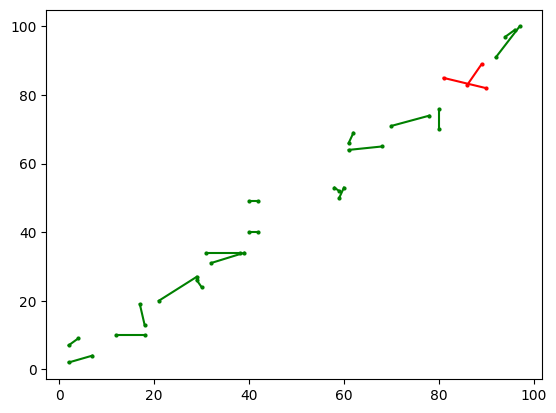

In [282]:
def intersect(coorA,coorB,coorC,coorD):
    # Return true if line segments AB and CD intersect
    def ccw(coorA, coorB, coorC):
        return (coorC.y-coorA.y) * (coorB.x-coorA.x) > (coorB.y-coorA.y) * (coorC.x-coorA.x)
    return ccw(coorA,coorC,coorD) != ccw(coorB,coorC,coorD) and ccw(coorA,coorB,coorC) != ccw(coorA,coorB,coorD)

n = 10
random_coor = lambda a,b : Coor((rd.randint(a,b), rd.randint(a,b)))
for i in range(10):
    a = random_coor(i*n, (i+1)*n)
    b = random_coor(i*n, (i+1)*n)
    c = random_coor(i*n, (i+1)*n)
    d = random_coor(i*n, (i+1)*n)
    color = "green"
    if intersect(a,b,c,d):
        color = "red"
    plt.plot([a.x, b.x], [a.y,b.y], "-o", color=color, markersize=2)
    plt.plot([c.x, d.x], [c.y,d.y], "-o", color=color, markersize=2)
plt.show()

In [283]:
RED = [255, 0, 0]
GREEN = [0, 255, 0]
BLUE = [0, 0, 255]
GREY = [70 for _ in range(3)]
WHITE = [240 for _ in range(3)]

START_CHAR = 2
CAR_CHAR = 4

def color_track(b):
    if b == START_CHAR:
        return GREEN
    elif b == 1:
        return GREY
    else:
        return WHITE
    

class Track():
    def __init__(self, tab, l_bt_lines=8, nb_lines=1, compute_lines=True):
        """ Track class
        
        l_bt_lines is the space between two lines

        nb_lines is tej inverse of the ratio you want to keep each lines
        i.e. nblines=n => keep on 1/n lines
        """

        #switching height and width for plan approach
        self.height, self.width = np.array(tab).shape
        self.basic_info_track:list = np.array(tab)
        
        self.info_track:list = [[0 for _ in range(self.height)] for _ in range(self.width)]
        for x in range(self.width):
            for y in range(self.height):
                self.info_track[x][y] = self.basic_info_track[self.height-1-y][x]

        self.color_track = [[color_track(self.info_track[x][y]) for x in range(self.width)] for y in range(self.height)]

        self.start = None
        for y in range(self.height):
            for x in range(self.width):
                if self.info_track[x][y] == START_CHAR:
                    self.start = Coor((x,y))

        self.basic_alpha = 0
    
        self.nb_lines = nb_lines
        self.lenght_bt_lines = l_bt_lines

        self.midpoints = []
        self.lines = []
        if compute_lines:
            self.midpoints, self.lines = self.create_lines(self.start)
            self.lines = [x for i,x in enumerate(self.lines) if i%nb_lines==0]
        

    def create_lines(self, coor:Coor):
        liste_coor = [coor]
        lines = []
        alpha = 0

        running = True
        while True:
            line, next_alpha, new_coor = self.create_line(liste_coor[-1])
            #plt.plot(liste_coor[-1].x, liste_coor[-1].y, "o", color="limegreen", markersize=3)
            liste_coor[-1] = new_coor

            coor_alpha = Coor((np.cos(alpha*np.pi/180), np.sin(alpha*np.pi/180)))
            coor_next_alpha = Coor((np.cos(next_alpha*np.pi/180), np.sin(next_alpha*np.pi/180)))
            if coor_alpha.x*coor_next_alpha.x + coor_alpha.y*coor_next_alpha.y<0:
                next_alpha = (next_alpha + 180) %360

            dx = np.cos(next_alpha*np.pi/180) * self.lenght_bt_lines
            dy = np.sin(next_alpha*np.pi/180) * self.lenght_bt_lines
            next_coor = Coor((dx,dy)) + liste_coor[-1]
            

            liste_coor.append(next_coor)
            lines.append(line)
            alpha = next_alpha
            
            if (not running) and intersect(new_coor, next_coor, lines[0][0], lines[0][1]):
                break
            running = False
            
        return liste_coor, lines


    def create_line(self, base_coor):
        min_lenght = self.height + self.width
        for alpha in range(0, 180):
            coor1_act = self.next_wall(base_coor, alpha)
            coor2_act = self.next_wall(base_coor, alpha+180)
            lenght_act = coor1_act.dist(coor2_act)

            if lenght_act<min_lenght:
                coor1 = Coor((coor1_act.x, coor1_act.y))
                coor2 = Coor((coor2_act.x, coor2_act.y))
                min_lenght = lenght_act
                basic_alpha = alpha-90

        return (coor1, coor2), basic_alpha, Coor(((coor1.x + coor2.x)/2, (coor1.y + coor2.y)/2 ))

    def get_color(self, coor:Coor):
        """return the color of the case x,y"""
        x,y = coor.get()
        return color_track(self.info_track[x][y])
    
    def is_wall(self, coor:Coor):
        """Return True if case (x,y) is a wall"""
        x,y = coor.get()
        nx,ny = int(round(x)), int(round(y))
        return (self.info_track[nx][ny] == 1)

    def get_start(self):
        """Return coordinate of start"""
        if self.start == None:
            return None
        return self.start.get()
    
    def get_end(self):
        """Return coordinate of end"""
        return self.end.get()
    
    def is_case_ridable(self, coor: Coor):
        """Return if the car can go on the coordinate or not"""
        x,y = coor.get()
        x,y = int(round(x)), int(round(y))
        if not (x>=0 and x<self.width and y>=0 and y<self.height):
            return False
        return not self.is_wall(coor)
    
    def is_move_possible(self, a:Coor, b:Coor) -> bool:
        """Return if the car can go from point a to b in straight line"""
        diff_x = b.x-a.x
        diff_y = b.y-a.y

        d = a.dist(b)
        if d<1:
            d = 1
        
        space = np.arange(0, 1, 1/d)
        for t in space:
            case = Coor((a.x+t*diff_x, a.y+t*diff_y))
            if not self.is_case_ridable(case):
                return False
        return True
    
    def is_case_in(self, coor:Coor):
        """return True is coor is in the tab"""
        return coor.x>=0 and coor.x<self.width and coor.y>=0 and coor.y<self.height
    
    def next_road(self, coor:Coor, alpha:float, dist_max=None):
        """Return the next in the line from coor to the first wall"""
        alpha = alpha % 360
        dx = np.cos(alpha * np.pi/180)
        dy = np.sin(alpha * np.pi/180)

        i = 0
        next_coor = Coor( (int(round(coor.x + i*dx)), int(round(coor.y + i*dy))) )
        while not self.is_case_ridable(next_coor):
            if ((dist_max!=None) and (coor.dist(next_coor) > dist_max)) or (not self.is_case_in(next_coor)):
                return None
            i += 1
            next_coor  = Coor( (int(round(coor.x + i*dx)), int(round(coor.y + i*dy))) )
        return next_coor

    def next_wall(self, coor:Coor, alpha:float, dist_max=None):
        """Return the next in the line from coor to the first wall"""
        alpha = alpha % 360
        dx = np.cos(alpha * np.pi/180)
        dy = np.sin(alpha * np.pi/180)

        i = 0
        next_coor = Coor( (int(round(coor.x + i*dx)), int(round(coor.y + i*dy))) )
        while self.is_case_ridable(next_coor):
            if (dist_max!=None) and (coor.dist(next_coor) > dist_max):
                break
            i += 1
            next_coor  = Coor( (int(round(coor.x + i*dx)), int(round(coor.y + i*dy))) )
        return next_coor

    def plot(self, hide=False, show_lines=False, show_midpoints=False):
        """Plot the track using matplotlib"""
        plt.imshow(self.color_track, origin='lower')

        if show_lines:
            for i in self.lines:
                liste_x = [coor.x for coor in i]
                liste_y = [coor.y for coor in i]
                plt.plot(liste_x, liste_y, '-', color="lightblue")

        if show_midpoints:
            for i in self.midpoints:
                plt.plot(i.x, i.y, 'o', color="lightblue", markersize=3)

        plt.plot(self.start.x, self.start.y, "o", color="limegreen")
            
        plt.axis("off")
        if not hide:
            plt.show()


### Creating tracks

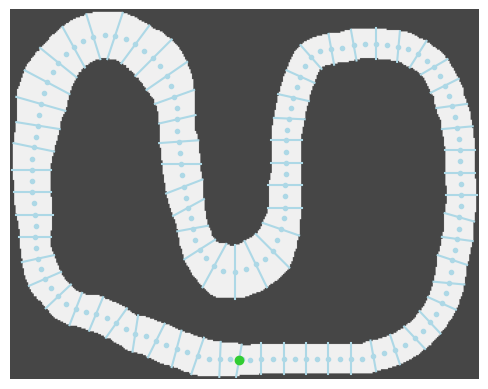

In [284]:
path = "../tracks/02.png"

from matplotlib.image import imread
from PIL import Image

def info_from_real_color(tab):
    x,y,z = tab[0], tab[1], tab[2]
    if x==0 and y==0 and z==0:
        return 1
    elif np.sqrt((x-255)**2 + (y-255)**2 + (z-255)**2) <= 25:
    #elif x==255 and y==255 and z==255:
        return START_CHAR
    else:
        return 0
    
def crop(tab):
    start = None
    for i,x in enumerate(tab):
        for j,y in enumerate(x):
            if y==START_CHAR:
                start = Coor((i,j))
    mini = Coor((start.x, start.y))
    maxi = Coor((start.x, start.y))

    for i,x in enumerate(tab):
        for j,y in enumerate(x):
            if y==0:
                if i<mini.x:
                    mini.x = i
                if j<mini.y:
                    mini.y = j
                if i>maxi.x:
                    maxi.x = i
                if j>maxi.y:
                    maxi.y=j
    
    k = 2
    res = [[y for j,y in enumerate(x) if mini.y-k<=j<=maxi.y+k] for i,x in enumerate(tab) if mini.x-k<=i<=maxi.x+k]
    return res

def create_track_info(path):
    img = Image.open(path)
    arr = np.array(img)
    img.close()
    return crop([[info_from_real_color(y) for y in x] for x in arr])

basic_track = Track(create_track_info("../tracks/02.png"), nb_lines=2, l_bt_lines=8)
basic_track.plot(show_lines=True, show_midpoints=True)

# Saving tracks lines

The goal here is to store all the tracks lines in .txt file so that we don't have to recalculate them.

The format is the following: each lines contain four number a,b,c,d which reprenset point (a,b) and (c,d) of a line.

Number of tracks: 87
[('../tracks2/post_images/01.png', '01'), ('../tracks2/post_images/02.png', '02'), ('../tracks2/post_images/03.png', '03'), ('../tracks2/post_images/04.png', '04'), ('../tracks2/post_images/05.png', '05'), ('../tracks2/post_images/06.png', '06'), ('../tracks2/post_images/07.png', '07'), ('../tracks2/post_images/08.png', '08'), ('../tracks2/post_images/09.png', '09'), ('../tracks2/post_images/10.png', '10'), ('../tracks2/post_images/11.png', '11'), ('../tracks2/post_images/12.png', '12'), ('../tracks2/post_images/13.png', '13'), ('../tracks2/post_images/14.png', '14'), ('../tracks2/post_images/15.png', '15'), ('../tracks2/post_images/16.png', '16'), ('../tracks2/post_images/17.png', '17'), ('../tracks2/post_images/18.png', '18'), ('../tracks2/post_images/19.png', '19'), ('../tracks2/post_images/20.png', '20'), ('../tracks2/post_images/21.png', '21'), ('../tracks2/post_images/22.png', '22'), ('../tracks2/post_images/23.png', '23'), ('../tracks2/post_images/24.png', '

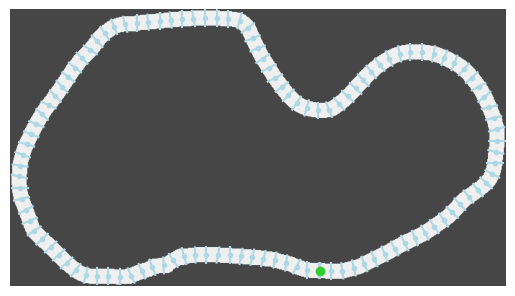

../tracks2/post_images/01.png as 114 lines


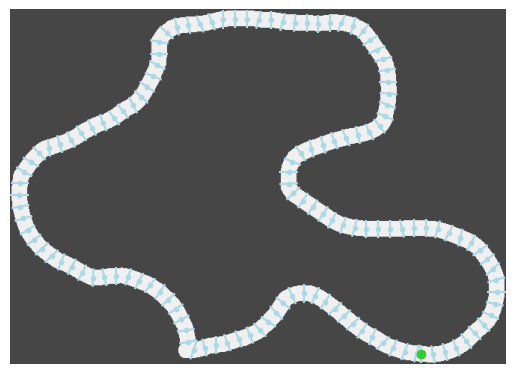

../tracks2/post_images/02.png as 132 lines


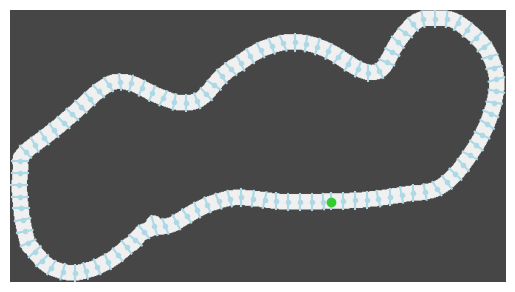

../tracks2/post_images/03.png as 107 lines


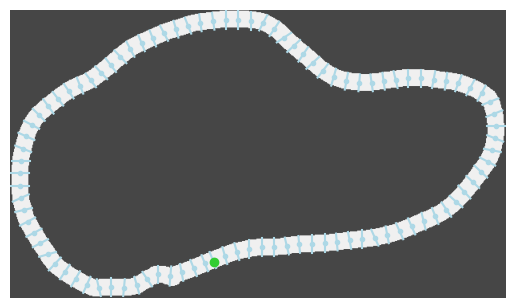

../tracks2/post_images/04.png as 96 lines


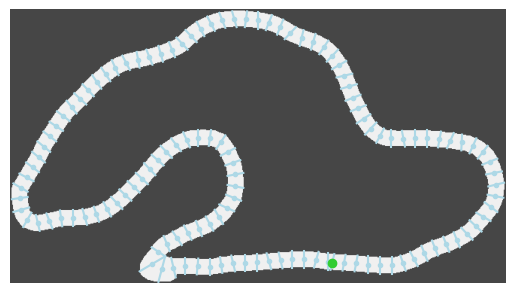

../tracks2/post_images/05.png as 122 lines


KeyboardInterrupt: 

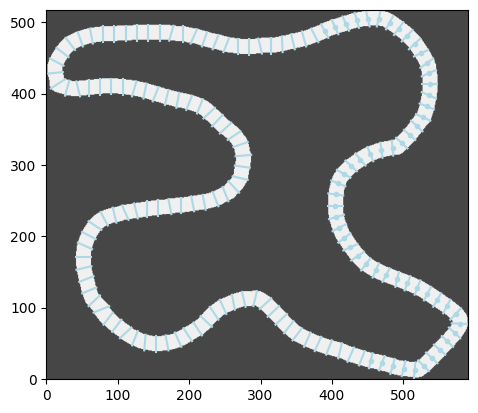

In [286]:
from os import walk

TRACKS_FOLDER = "../tracks2/post_images/"
LINES_FOLDER = "../track_lines/"

PATHS = []
for (dirpath, dirnames, filenames) in walk(TRACKS_FOLDER):
    for file in filenames:
        file_path = TRACKS_FOLDER + file
        PATHS.append((file_path, file[:-4]))
    break

PATHS.sort()
# Tracks to del: 29, 40, 49, 65, 84, 92
to_del = [29, 40, 49, 65, 84, 92]
to_del.sort(key=lambda x:-x)
for x in to_del:
    del PATHS[x-1]

#PATHS = PATHS[:10]

print("Number of tracks:", len(PATHS))
print(PATHS)


def save_lines(track:Track, path:str):
    file = open(path, "w")
    for c1,c2 in track.lines:
        txt = str(c1.x) + "," + str(c1.y) + "," + str(c2.x) + "," + str(c2.y) +"\n" 
        file.write(txt)
    file.close()


def save_tracks_lines():
    # put all the tracks path here:
    # The track called O3.png is not working because of unsmooth corner
    for name, number in PATHS:
        track_info = create_track_info(name)
        track = Track(track_info, nb_lines=2, l_bt_lines=8)
        save_lines(track, LINES_FOLDER + number + ".txt")
        print(name, number)


def create_tracks():
    tracks = []
    for name, number in PATHS:
        track_info = create_track_info(name)
        track = Track(track_info, nb_lines=2, l_bt_lines=8, compute_lines=False)
        file = open(LINES_FOLDER + number + ".txt", "r")

        for lines in file:
            a,b,c,d = lines.split(",")
            a,b,c,d = int(a), int(b), int(c), int(d)
            c1 = Coor((a,b))
            c2 = Coor((c,d))
            track.lines.append((c1,c2))
            track.midpoints.append(Coor(((c1.x+c2.x)/2, (c1.y+c2.y)/2)))
        file.close()
        tracks.append(track)

        tracks[-1].plot(show_lines=True, show_midpoints=True)
        print(name, "as", len(tracks[-1].lines), "lines")

    return tracks


#save_tracks_lines() # uncomment to not recalculate lines

TRACKS:list[Track] = create_tracks()

#Do not execute next for saving tracks line

### Car class

Car has $2$ main variable:
 - speed: $v$
 - alpha: $\alpha$ suppose to be between $0$ and $360$

To calculate the $x$-speed and $y$-speed we use the next formulas:
 - $v_x = v.cos(\alpha . \frac{\pi}{180})$
 - $v_y = v.sin(\alpha . \frac{\pi}{180})$

In [ ]:
"""Constant"""
MAX_SPEED = 50
MAX_TURN = 20

"""Class"""
class Car():
    def __init__(self, coor:Coor, time):
        self.coor: Coor = Coor((coor.x, coor.y))
        self.speed: float = 0
        self.alpha: float = 0 # The angle of the car according to unitary cicrle
        self.trajectory = [[Coor((coor.x, coor.y)), 0]]
        self.previous_speed: float = 0
        self.time = time

        self.max_turn = 20 * self.time
        self.max_speed = 50 * self.time
        self.acceleration_constant = 3 * self.time
        self.brake_constant = 6 * self.time

    def __str__(self):
        return "C[" + str(self.coor) + " " + str(self.speed) + " " + str(self.alpha) + "]"
    

    def accelerate(self, amont=1):
        """Increase speed of the car"""
        self.speed += amont * self.acceleration_constant
        self.speed = min(self.speed, self.max_speed)
        

    def brake(self, amont=1):
        """Decrease speed of the car (can't drive backward)"""
        self.speed -= amont * self.brake_constant
        if self.speed < 0:
            self.speed = 0

    def turn(self, deg):
        """Change the current rotation of the car"""
        if np.absolute(deg) > self.max_turn:
            print(deg)
            assert False
        self.alpha += deg
        self.alpha = self.alpha % 360

    def get_speed_coor(self):
        cst: float = np.pi / 180
        dx: float = self.speed * np.cos(self.alpha * cst)
        dy: float = self.speed * np.sin(self.alpha * cst)
        return Coor((dx,dy))

    def move(self):
        """Change the coordinate of the care according to its speed and alpha"""
        speed_increase = 0
        if self.previous_speed < self.speed:
            speed_increase = 1
        elif self.previous_speed > self.speed:
            speed_increase = -1
        self.previous_speed = self.speed

        dx,dy = self.get_speed_coor().get()
        self.coor.x += dx
        self.coor.y += dy
        self.trajectory.append([Coor((self.coor.x, self.coor.y)), speed_increase])

    def dic(self):
        return {"coor":self.coor, "speed":self.speed, "alpha":self.alpha, "trajectory":self.trajectory}

    def plot(self, markersize=8, vector_constant=2, show_trajectory=False, head_width=1):
        """Plot the car and is speed vectors"""
        # Plot car
        x,y = self.coor.get()
        plt.axis("off")

        # Plot 
        if show_trajectory:
            liste_x = [i[0].x for i in self.trajectory]
            liste_y = [i[0].y for i in self.trajectory]

            for i in range(1, len(self.trajectory)):
                color = "yellow"
                if self.trajectory[i][1] == 1:
                    color = "green"
                elif self.trajectory[i][1] == -1:
                    color = "red"
        
                plt.plot([liste_x[i-1], liste_x[i]], [liste_y[i-1], liste_y[i]], "-o", color=color, markersize=2)
                 
        # Plot car's directoin
        cst: float = np.pi / 180
        dx: float = np.cos(self.alpha * cst)
        dy: float = np.sin(self.alpha * cst)
        plt.arrow(x, y, dx/10, dy/10, head_width=head_width)
        plt.plot([x, x+ dx*self.speed*vector_constant], [y, y+ dy*self.speed*vector_constant], "-", color="red")
        plt.plot(x, y, "o", color='blue', markersize=markersize)


### Gym env

We need to transform a actual action $(a, \alpha) \in \{-1,0,1\} \times \{-K,...,K\}$ where $K =$ `MAX_TURN` to a action in $\{0,...,N-1\}$.

Then we need a bijection
$$\phi : \{-1,0,1\} \times \{-K,...,K\} \rightarrow \mathbb{Z}_N$$

We can take
$$\phi(a,b) = 3(b+K) + (a+1)$$

Then,
$$\phi^{-1}(x) = ((x\; mod\; 3)-1, \frac{1}{3}x -K)$$

Moreover, we have $N = 3\times 2K+1 = 6K+3$

In [ ]:
MAX_SPEED = 50
MAX_TURN = 20

class RacingCar(Env):
    def __init__(self):
        super(RacingCar, self).__init__()
        # time between two frames
        self.time = 0.9 #Change this variable to "discretiser" the time. Lower value means more discretisation

        self.max_turn = int(MAX_TURN * self.time)
        self.nb_state = 6*self.max_turn + 3
        self.max_speed = int(MAX_SPEED * self.time)

        # Define an action space ranging from 0 to 3
        self.action_space = [self.int_to_action(i) for i in range(self.nb_state)]
        self.int_action_space = [i for i in range(self.nb_state)]

        self.track: Track = None
        self.id_line_goal = 0

        # Define the anle of which we will look the distance
        self.liste_alpha = [60, 40, 20, 0, -20, -40, -60]
        self.max_dist_wall = None

        self.reward_max = 200
        
        self.car: Car = None

    def create_car(self):
        car = Car(self.track.start, self.time)
        return car

    def action_to_int(self, action):
        """Transform an action (tuple) into an action (int)"""
        a,b = action
        return 3*(b+self.max_turn) + a+1
    
    def int_to_action(self, x):
        """Transform an action (int) into an action (tuple)"""
        return ((x%3)-1, int(x/3) -self.max_turn)


    def get_state(self):
        """Return actual state of the env"""
        state = [self.car.speed]
        for alpha in self.liste_alpha:
            coor = self.track.next_wall(self.car.coor, self.car.alpha + alpha, dist_max=self.max_dist_wall)
            state.append(self.car.coor.dist(coor))
        return state

    def reset(self, track):
        """Reset the environment"""
        self.id_line_goal = 0
        self.track = track
        self.max_dist_wall = self.track.height + self.track.width

        self.car = self.create_car()
        return self.get_state(), []

    def render(self, waiting_time=0.01,
               show_trajectory=False, show_dist_to_wall=False,
               show_track_midpoint=False, show_track_lines=False):
        """Render the environment"""
        self.track.plot(hide=True, show_lines=show_track_lines, show_midpoints=show_track_midpoint)
        if show_dist_to_wall:
            for alpha in self.liste_alpha:
                coor = self.track.next_wall(self.car.coor, self.car.alpha + alpha, dist_max=self.max_dist_wall)
                plt.plot([self.car.coor.x, coor.x], [self.car.coor.y, coor.y], "-", color="grey")

        self.car.plot(show_trajectory=show_trajectory)
        display.clear_output(wait=True)
        plt.show()
        time.sleep(waiting_time)
        
    def step(self, action:int):
        """Do a step, we suppose that the action is a possible one"""
        is_done = False
        reward = 0

        x,y = self.car.coor.get()
        previous_coor = Coor((x,y))

        acc, turn = self.int_to_action(action)
        if acc==-1:
            self.car.brake()
        elif acc==1:
            self.car.accelerate()
        self.car.turn(turn)
        self.car.move()

        new_coor = self.car.coor

        has_crashed = False
        if not self.track.is_move_possible(previous_coor, new_coor):
            has_crashed = True
            reward -= 500
            is_done = True

        if self.car.speed == 0:
            reward -= 10
        
        reward += self.car.speed/10
        
        previous_id = (self.id_line_goal-1) % (len(self.track.lines))

        if intersect(self.track.lines[previous_id][0], self.track.lines[previous_id][1], previous_coor, new_coor):
            reward -= 200
            is_done = True

        while intersect(self.track.lines[self.id_line_goal][0], self.track.lines[self.id_line_goal][1], previous_coor, new_coor) and not has_crashed:
            reward += 10
            self.id_line_goal = (self.id_line_goal + 1) % (len(self.track.lines))

        reward -= 1
        return self.get_state(), reward, is_done, has_crashed, []
    
    def random_action(self, p_accel=0.25, p_brake=0.25, p_turn=0.5):
        """Return random possible action according to probability"""
        action = [0,0]
        rd_accel = rd.random()
        if rd_accel <= p_accel:
            action[0] = 1
        elif rd_accel <= p_accel + p_brake:
            action[0] = -1
        
        if rd.random() <= p_turn:
            action[1] = ((-1)**(rd.randint(0,1))) * rd.randint(-self.max_turn, self.max_turn)
        return tuple(action)

### Env example

In [ ]:
# env = RacingCar()
# env.reset(basic_track)
# env.track.plot(show_lines=True)

In [ ]:
# print(env.nb_state)
# print(env.action_space)
# for i in range(env.nb_state):
#     acc,turn = env.int_to_action(i)
#     if (np.absolute(turn) > env.max_turn) or (np.absolute(env.action_space[i][1]) > env.max_turn):
#         assert False

In [ ]:
# moves = [[Coor((60, 25)), Coor((100,28))],
#          [Coor((125, 60)), Coor((105, 80))],
#          [Coor((240,160)), Coor((180, 110))],
#          [Coor((363.5,140)), Coor((359.2, 260))],
#          [Coor((240, 230)), Coor((240, 230))],
#          [Coor((290, 200)), Coor((290, 200))]]

# for coors in moves:
#     res = env.track.is_move_possible(coors[0], coors[1])
#     color = "limegreen"
#     if not res:
#         color = "red"
#     plt.plot([coors[0].x, coors[1].x], [coors[0].y, coors[1].y], "-o", markersize=4, color=color)

# env.track.plot(hide=True)
# plt.plot()

In [ ]:
# env.reset(basic_track)

# actions = [(1,-5), (1, -10), (1,0), (1,0), (1,10), (1, 10), (1,0), (1,0),
#            (1, env.max_turn), (1, env.max_turn), (-1, env.max_turn), (-1, env.max_turn), (-1, 0), (-1, 0), (-1, 0),
#            (-1, 0), (-1, 0), (-1, 0), (-1, 0),
#            (-1, -env.max_turn), (-1, -env.max_turn), (-1, -env.max_turn), (-1, -env.max_turn), (-1, -env.max_turn), (-1, -env.max_turn),
#            (-1, -env.max_turn), (-1, -env.max_turn), (-1, -env.max_turn), (-1, -env.max_turn),
#            (1, 0), (1, 0), (1, 0), (1, 0), (1, 0)]

# reward_list = []
# for action in actions:
#     if np.absolute(action[1]) <= env.max_turn:
#         _, reward, _, _, _= env.step(env.action_to_int(action))
#         reward_list.append(int(reward*100)/100)
#         env.render(show_trajectory=True, show_dist_to_wall=True, show_track_lines=True)
    
# print(env.get_state())
# print(reward_list)
# env.close()

# Reset example

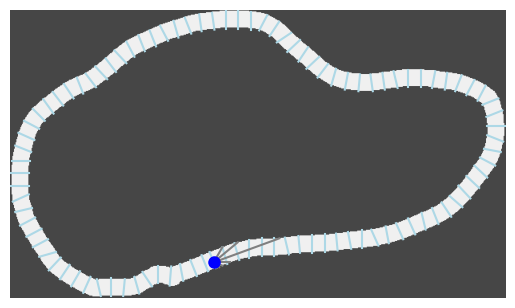

In [ ]:
# Create the env
env = RacingCar()

# tracks is a list comporting all tracks
# choose a index of the list
id = rd.randint(0, len(TRACKS)-1)

# reset the env with the track
env.reset(TRACKS[id])

# Render with some options
env.render(show_dist_to_wall=True, show_track_lines=True)

# Close the env
env.close()

In [ ]:
# Essentials for training and env

# For NN
import torch 
import torch.nn as nn 
import torch.functional as F
import torch.optim as optim

# For math computations
# import numpy as np

# For random as rd
# import random 

# For envs
# import gymnasium

# For time limit
# import time

# structure to save transitions 
from collections import namedtuple , deque
Transition = namedtuple("Transition",["state","action","next_state","reward"])

In [ ]:
# For plots
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

# For saving files
from datetime import datetime

# for model vizualisation 
from torchsummary import summary

In [ ]:
class ReplayMemory():
    def __init__(self,maxlen : int):
        self.memory_ = deque(maxlen=maxlen)

    def push(self,x : Transition):
        self.memory_.append(x)

    def sample(self,batch_size : int) -> list[Transition]:
        return rd.sample(self.memory_,batch_size)
    
    def clear(self):
        return self.memory_.clear()
    
    def __len__(self):
        return len(self.memory_)

In [ ]:
class DQN(nn.Module):
    def __init__(self,layer_size,state_size,action_n):
        super(DQN,self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_size,layer_size),
            nn.ReLU(),

            nn.Linear(layer_size,layer_size),
            nn.ReLU(),

            nn.Linear(layer_size,layer_size),
            nn.ReLU(),

            nn.Linear(layer_size,action_n),
        )

    def forward(self,x):
        return self.network(x)
    
    def save(self,filename : str = None):
        if (filename == None):
            filename = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
        torch.save(self.state_dict(),filename)

    def load(self,filename : str):
        self.load_state_dict(torch.load(filename, weights_only=True))

In [ ]:
class Env():
    def __init__(self):
        """ track_name is the name of the track file"""
        # Toujours là
        self.done = False

        # Pour faire step, reset, state pour cette implementation
        self.env = RacingCar()
        self.state_gym,_ = self.env.reset(TRACKS[0])
        self.n_action = self.env.nb_state

        # Décrit le model actuel
        self.model = DQN(400,8,self.n_action)

        # Décrit les transitions observées jusqu'à présent
        self.memory = ReplayMemory(10000)

        # Pour normaliser la Q table
        self.discount_factor = 0.9

        self.track_for_training = int(len(TRACKS)*0.8)

    def state(self):
        """ On définit un état comme étant un batch de taille 1 ou None"""
        if (self.state_gym == None or self.done) :
            return None
        else :
            arr = np.array(self.env.get_state())
            arr = arr / max(MAX_SPEED, self.env.max_dist_wall) #To normalize the array
            return torch.tensor([arr],dtype=torch.float)

    def show_state(self):
        self.env.render(show_trajectory=True)

    def reset(self):
        """Reset the environment"""
        rd_track = rd.randint(0, self.track_for_training -1)
        self.state_gym , _ = self.env.reset(TRACKS[rd_track])
        self.done = False
    
    def dist(state):
        """Calcule la longueur d'un plus court chemin entre state et goal (sous forme d'un flotant)"""
        goal = torch.tensor([[11,3]],dtype=torch.float)
        start = torch.tensor([[0,3]],dtype=torch.float)
        if (torch.equal(state,start)):
           return torch.tensor(13,dtype=torch.float)
        else :
           return torch.sum(torch.abs(state-goal))
       
    def step(self,action : torch.tensor) :
        """ Fais un pas depuis l'état actuel via l'action donnée et renvoit la transition observéex
            Une action est un tenseur contenant un seul scalaire """
        if (self.done):
            raise(ValueError("Trying to move from a final state"))

        prev_state = self.state()

        # do the step and update the new gym state
        acc, turn = self.env.int_to_action(action.item())
        if np.absolute(turn) > self.env.max_turn:
            print(action.item(), (acc, turn))
            
        self.state_gym,reward,terminated,truncated,_ = self.env.step(action.item())
        self.done = terminated or truncated

        next_state = self.state()

        reward_normalizer = self.env.reward_max
        qtable_normalizer = 1/(1-self.discount_factor)
        reward = torch.tensor(reward/(reward_normalizer*qtable_normalizer), dtype=torch.float).reshape((1,1))
        action = torch.tensor(action.item()).reshape((1,1))

        transition = Transition(prev_state, action, next_state , reward)
        return transition
    
    def policy(self):
        if (self.done):
            raise(ValueError("Trying to predict a move from a final state"))
        return self.model(self.state()).max(1).indices.reshape((1,1))
    
    def random_action(self) -> torch.tensor :
        if (self.done):
            raise(ValueError("Trying to sample a move from a final state"))
        action = rd.randint(0,self.n_action-1)
        return torch.tensor(action).reshape((1,1))

In [ ]:
def optimize(env : Env,optimizer,criterion,batch_size,discount_factor):
    if (len(env.memory) < batch_size) :
        return 

    # A list of batch_size transtions
    transition = env.memory.sample(batch_size)

    # A tuple with four coordinates : 
    # state -> a batch of size batch_size of states 
    # action -> a batch of size batch_size of actions
    # ect
    batch = Transition(*zip(*transition))

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Batch of size batch_size of the Qvalue predicted by our current model, for the state and action of a transtion
    predicted = env.model(state_batch).gather(1,action_batch)

    next_state_value = torch.zeros((batch_size,1))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool )
    if non_final_mask.any():
        non_final_next_state = torch.cat([s for s in batch.next_state if s is not None])
        with torch.no_grad():
            next_state_value[non_final_mask] = env.model(non_final_next_state).max(1).values.unsqueeze(1)

    expected = reward_batch + (discount_factor * next_state_value)

    optimizer.zero_grad()
    loss = criterion(predicted,expected)
    loss.backward()
    torch.nn.utils.clip_grad_value_(env.model.parameters(), 100)
    optimizer.step()

In [ ]:
def measure_policy_time(env) :
    env.reset()
    time_deb = time.perf_counter()
    env.policy()
    return time.perf_counter() - time_deb

In [ ]:
def measure_model_size(env):
    return sum(p.numel() for p in env.model.parameters())

In [ ]:
def evaluate_model_reward(env):
    sum = 0
    max_step = 300
    for i in range(env.track_for_training,len(TRACKS)) :
        env.state_gym , _ = env.env.reset(TRACKS[i])
        env.done = False
        i = 0
        while(i < max_step and not(env.done)) :
            i+=1
            transition = env.step( env.policy() )
            sum += transition.reward.item()
    return sum/( len(TRACKS) - env.track_for_training)

In [ ]:
def training(lr=1e-4,epsilon_decay=30.,batch_size = 40,time_bound = 60*(1),track_budget=int(0.8*len(TRACKS))):
    #env.model.load(filename)
    env = Env()
    filename =  "saved_model/"  + datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

    # track budget for training
    env.track_for_training = track_budget

    # Hyperparameters
    #batch_size = 40
    epochs = 5000
    max_episode_duration = 1000 * 1/env.env.time
    epsilon_max = 1
    epsilon_min = 0.01
    #epsilon_decay = 30.
    #lr = 1e-4
    discount_factor = 0.9
    env.discount_factor = discount_factor
    optimizer = optim.AdamW(env.model.parameters(), lr=lr, amsgrad=True)
    criterion = nn.SmoothL1Loss()

    env.memory.clear()

    reward_history = []
    reward_time = []
    volatility_history = []
    volatility_time = []

    #time_bound = 60*(1)
    time_start = time.perf_counter()
    i = 0
    while (i < epochs and ( (time.perf_counter() - time_start <= time_bound)  )):
        i += 1
        env.reset()
        epsilon = epsilon_min + (epsilon_max-epsilon_min)*np.exp(-i/epsilon_decay)
        it_counter = 0
        reward = 0
        while(not(env.done) and it_counter < max_episode_duration):
            it_counter += 1
            # Chose an action
            if (rd.random() <= epsilon):
                action = env.random_action()
            else:
                with torch.no_grad() :
                    action = env.policy()

            # Apply the transition and save it in memory
            transition = env.step(action)
            reward += (transition.reward).item()
            env.memory.push(transition)
            # Optimize by observing batch_size random transitions
            optimize(env,optimizer,criterion,batch_size,discount_factor)
        # Stats about the training
        second = (int(time.perf_counter() - time_start)) % 60
        minute = (int(time.perf_counter() - time_start)) //60
        if (minute%5 == 0 and minute > 3) :
            env.model.save(filename)

        if ( second <= 3  ) :
                env.show_state()
        normalizer = 1
        window_len = 30
        iteration_time = time.perf_counter() - time_start
        reward_history.append(reward*normalizer)
        reward_time.append( iteration_time  )
        last_window = reward_history[-window_len:]
        volatility_history.append(np.std(last_window))
        volatility_time.append(iteration_time)
        

    res = {}
    res["training_time"] = time_bound
    res["track_number"] = len(TRACKS)
    res["global_volatility"] = np.std(reward_history)
    res["model_size"] = measure_model_size(env)
    res["policy_time"] = measure_policy_time(env)
    res["policy_score"] = evaluate_model_reward(env)
    res["reward_history"] = reward_history
    res["reward_time"] = reward_time 
    res["volatility_history"] = volatility_history
    res["volatility_time"] = volatility_time 
    res["DQN_model_param"] = filename
    res["DQN_model_param_is_saved"] = False

    minute = (int(time.perf_counter() - time_start)) //60
    if (minute > 3) :
         env.model.save(filename)
         res["DQN_model_param_is_saved"] = True

    plt.plot(reward_history)
    plt.plot(volatility_history)
    plt.show()
    
    return res

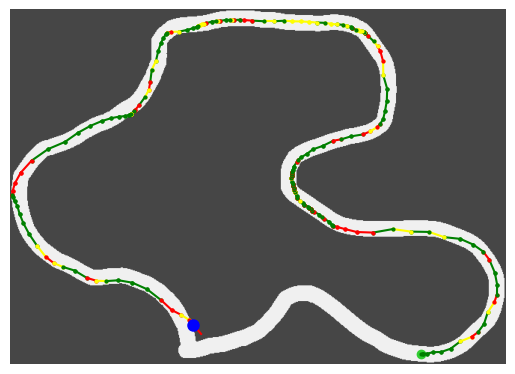

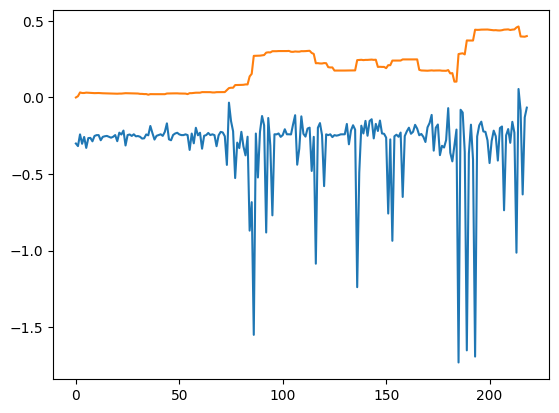

In [ ]:
res = training()

In [ ]:
import json

In [ ]:
def par1_data():
    training_times_min = [10,30,60]
    training_times_sec = [60*i for i in training_times_min]
    track_limit = [10,50,len(TRACKS)]
    if (len(TRACKS) < max(track_limit)) :
        raise(ValueError("not enough tracks"))
    folder_name =  "run_part1_"+ datetime.now().strftime("%Y-%m-%d_%H:%M:%S") + "/"
    for t in training_times_sec :
        for n_track in track_limit :
            json_object = json.dumps( training(time_bound=t,track_budget=n_track))
            with open(folder_name + str(t)+"_"+str(n_track)+".json") as f :
                f.write(json_object)
    
    

In [ ]:
print(res)

{'training_time': 60, 'track_number': 10, 'global_volatility': 0.24663145959737598, 'model_size': 368911, 'policy_time': 0.0022050829138606787, 'policy_score': -0.07481750120859942, 'reward_history': [-0.3006900093751028, -0.31755500930012204, -0.24101500981487334, -0.30255498868064024, -0.2579200141772162, -0.3294499883559183, -0.26541000475845067, -0.26401498882478336, -0.2863800093473401, -0.2514200098521542, -0.24605498891469324, -0.2458250141935423, -0.27938000971334986, -0.2573249888664577, -0.2532450095168315, -0.2511500051259645, -0.25692000982235186, -0.262774988412275, -0.2566500050961622, -0.24565000515576685, -0.2855549887462985, -0.22988498884660657, -0.24220500543015078, -0.21616999695834238, -0.3134750095778145, -0.24565000515576685, -0.24165001407527598, -0.2511500051259645, -0.24047500044252956, -0.25388000954990275, -0.2518800142715918, -0.2565150052905665, -0.2684199886061833, -0.26672001432598336, -0.24143500056379708, -0.2472450098139234, -0.18624000586714828, -0.2

In [ ]:
print(res["policy_score"])

-0.07481750120859942
